In [ ]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [3]:
dim = 4

In [9]:
class GradientNorm(tf.train.Optimizer):
    def __init__(self, learning_rate=0.1, use_locking=False, name="GradientNorm"):
        super().__init__(use_locking, name)
        self._lr = learning_rate
        
        # Tensor versions of the constructor arguments, created in _prepare().
        self._lr_t = None

    def _prepare(self):
        self._lr_t = tf.convert_to_tensor(self._lr, name="learning_rate")

    def _apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        var_update = tf.assign_sub(var, lr_t * tf.linalg.l2_normalize(grad, axis=1))
        
        return tf.group(*[var_update])

    def _apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

In [12]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        np.random.seed(0)
        params_value = np.tile(np.random.randn(1, n), [batch_size, 1])
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.constant_initializer(params_value))
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def batch_solve_tensorflow(batch_size):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant([1] + [0] * (dim - 1), dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.tile(tf.expand_dims(tf.constant([0] * (dim - 1) + [1], dtype='complex128'), axis=0), [batch_size, 1])
        h = h_generator(batch_size)
        
        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = -tf.reduce_sum(fidelities)
        
        optimizer = GradientNorm(learning_rate=0.5)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)
        
    with tf.Session() as session:
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        
        for i in tqdm(range(100)): # todo, improve stop
            session.run(optimize_op)
            
        return session.run(fidelities), session.run(gradients)

In [15]:
f, g = batch_solve_tensorflow(10)

(array([   0.,    0.,    0.,    0.,    0., 1024.,    0.,    0.,    0.,
           0.]),
 array([0.46521524, 0.56521524, 0.66521524, 0.76521524, 0.86521524,
        0.96521524, 1.06521524, 1.16521524, 1.26521524, 1.36521524,
        1.46521524]),
 <a list of 10 Patch objects>)

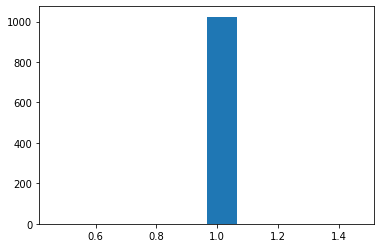

In [14]:
plt.hist(f.squeeze())

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([0.46521524, 0.56521524, 0.66521524, 0.76521524, 0.86521524,
        0.96521524, 1.06521524, 1.16521524, 1.26521524, 1.36521524,
        1.46521524]),
 <a list of 10 Patch objects>)

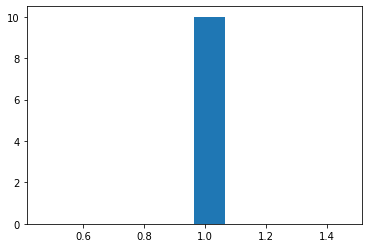

In [16]:
plt.hist(f.squeeze())

In [83]:
g

[(array([[-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         ...,
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447]]),
  array([[1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         ...,
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798]])),
 (array([[ 0.0020342 , -0.00422815, -0.00197394,  0.00416788],
         [ 0.0020342 , -0.00422815, -0.00197394,  0.00416788],
         [ 0.0020342 , -0.00422815, -0.00197394,  0.00416788],
         ...,
         [ 0.0020342 , -0.00422815, -0.00197394,  0.00416788],
         [ 0.0020342 , -0.00422815, -0.00197394,  0.00416788],
         [ 0.0020342 , -0.00422815, -0.00197394,  0.0041

In [85]:
g

[(array([[-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447],
         [-0.0336351 , -0.2163689 , -0.08036447]]),
  array([[1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798],
         [1.76405235, 0.40015721, 0.97873798]])),
 (array([[ 0.0020342 , -0

In [119]:
p = tf.placeholder(shape=(1024, 4), dtype='complex128')
(p / tf.norm(p, axis=-1)).shape

ValueError: Dimensions must be equal, but are 4 and 1024 for 'truediv' (op: 'RealDiv') with input shapes: [1024,4], [1024].